# Table of contents
- [Date and Time Data Types and Tools](#Date-and-Time-Data-Types-and-Tools)
- [Time Series Basics](#Time-Series-Basics)
- [DateRanges, Frequencies, and Shifting](#Date-Ranges,-Frequencies,-and-Shifting)
- [Time zone handling](#Time-zone-handling)
- [Resampling and Frequency Conversion](#Resampling-and-Frequency-Conversion)
- [Moving Window Functions](#Moving-Window-Functions)


Most of the content of this notebook is based on the following books:

- "[Python for Data Analysis](https://www.oreilly.com/library/view/python-for-data/9781491957653/)" (Chapter 11)
    - Author: Wes McKinney 
    - Relased: October 2017
    - Publisher: O'Reilly Media, INC. 
    - ISBN: 9781491957660
- "[Practical Time Series Analysis. Prediction with Statistics & Machine Learning](https://www.oreilly.com/library/view/practical-time-series/9781492041641/)"
    - Author: Aileen Nielsen
    - Released: October 2019
    - Publisher: O'Reilly Media, INC. 
    - ISBN: 9781492041658

In [1]:
import numpy as np
import pandas as pd
import math
np.random.seed(12345)
import matplotlib.pyplot as plt

**Time series** is an important form of structured data, with application in many fields.

In **medicine**, for instance, time-series analysis for individual patients has been widely investigated. The first practical electrocardiograms (ECGs) were invented in the early 20th century and enabled the diagnosis of cardiac conditions by recording electrical signals from the heart. The electroencephalogram (EEG) was introduced in 1924: it measures the electrical impulses in the brain. Nowadays, the pervasiveness of wearable sensors and smart devices leads to the widespread collection of large amount of longitudinal data both from sick and healthy subjects.

Time series analysis and forecasting plays a central role in **meteorology**, since the dawn of civilisation.

Other examples range from the forecasting of **economic growth** and trading markets to **astronomy**, leading to the analysis of variable stars and the observation of transitory events such as supernovae.




A time series consists of a sequence of observation over time. Each observation may be associated with:
- a *timestamp*, specific instants in time
- a fixed *period*, such as a whole year, or month, or day
- an *interval* of time, i.e. a time frame between two timestamps.

The python standard library and `pandas` (originally developed by Wes Mckinney) have many built-in tools and algorithms for handling time series.

The name `pandas` is actually derived from the term "panel data", which refers to multi-dimensional data involving measurements over time.

## Date and Time Data Types and Tools

`datetime` stores the date and time down to microseconds

In [2]:
from datetime import datetime
now = datetime.now()
print(now, type(now))
now 


2022-12-05 18:03:33.749875 <class 'datetime.datetime'>


datetime.datetime(2022, 12, 5, 18, 3, 33, 749875)

In [3]:
now.year, now.month, now.day, now.microsecond

(2022, 12, 5, 749875)

The time difference between two datetime objects is represented by the `timedelta` object

In [4]:
delta = datetime(2011, 1, 7) - datetime(2008, 6, 24, 8, 15)
delta

datetime.timedelta(days=926, seconds=56700)

In [5]:
delta.days, delta.seconds

(926, 56700)

In [6]:
dir(delta)

['__abs__',
 '__add__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pos__',
 '__radd__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 'days',
 'max',
 'microseconds',
 'min',
 'resolution',
 'seconds',
 'total_seconds']

`timedelta` can also be used to obtain a shifted object

In [7]:
from datetime import timedelta
start = datetime(2011, 1, 7)
start + timedelta(12) # first parameter is day but can be tuned up till weeks and down till milliseconds

datetime.datetime(2011, 1, 19, 0, 0)

In [8]:
start - 2 * timedelta(12)

datetime.datetime(2010, 12, 14, 0, 0)

### Converting between String and Datetime

It is often the case that datetime information are stored as strings. We can easily convert to `datetime` object using a format specification.

In [9]:
value = "2011-01-03"
datetime.strptime(value, "%Y-%m-%d") #string parsing

datetime.datetime(2011, 1, 3, 0, 0)

Whole list of format codes available in the [docs](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes).

In [10]:
datestrs = ["7/6/2011", "8/6/2011"]
[datetime.strptime(x, "%m/%d/%Y") for x in datestrs] #string parsing

[datetime.datetime(2011, 7, 6, 0, 0), datetime.datetime(2011, 8, 6, 0, 0)]

Vice versa, we can pass from `datetime` to strings using `strftime`.

In [11]:
stamp = datetime(2011, 1, 3)
str(stamp)
stamp.strftime("%Y-%m-%d"), type(stamp.strftime("%Y-%m-%d")) #string formatting

('2011-01-03', str)

`pandas` offers a specific method for parsing strings with timestamp information

In [12]:
datestrs = ["2011-07-06 12:00:00", "2011-08-06 00:00:00"]
pd.to_datetime(datestrs)

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00'], dtype='datetime64[ns]', freq=None)

In [13]:
pd.to_datetime?

In [14]:
idx = pd.to_datetime(datestrs + [None])
idx

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00', 'NaT'], dtype='datetime64[ns]', freq=None)

For datetime64[ns] types, NaT represents missing values.

In [15]:
idx[2], type(idx[2])

(NaT, pandas._libs.tslibs.nattype.NaTType)

In [16]:
pd.isna(idx)

array([False, False,  True])

## Time Series Basics

A time series object can be represented in pandas as a Series indexed by timestamps (`datetime` objects).

In [17]:
dates = [datetime(2011, 1, 2), datetime(2011, 1, 5),
         datetime(2011, 1, 7), datetime(2011, 1, 8),
         datetime(2011, 1, 10), datetime(2011, 1, 12)]
ts = pd.Series(np.random.standard_normal(6), index=dates)
ts

2011-01-02   -0.204708
2011-01-05    0.478943
2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

In [18]:
ts.index

DatetimeIndex(['2011-01-02', '2011-01-05', '2011-01-07', '2011-01-08',
               '2011-01-10', '2011-01-12'],
              dtype='datetime64[ns]', freq=None)

In [19]:
ts.index.dtype

dtype('<M8[ns]')

The general dtype `datetime64[ns]` maps to either `<M8[ns]` or `>M8[ns]` depending on the endian-ness of the machine.

In [20]:
stamp = ts.index[0]
stamp

Timestamp('2011-01-02 00:00:00')

Scalar values from a `DatetimeIndex` are pandas `Timestamp` objects

### Indexing, Selection, Subsetting

Time series can be indexed as classical pandas Series objects.

In [21]:
stamp = ts.index[2]
ts[stamp]

-0.5194387150567381

We can also use strings, as long as they can be interpreted as datetime

In [22]:
ts["2011-01-10"]

1.9657805725027142

**Slicing on time series**

In [23]:
longer_ts = pd.Series(np.random.standard_normal(1000),
                      index=pd.date_range("2000-01-01", periods=1000)) # 1000 days starting from first arg.
longer_ts

2000-01-01    0.092908
2000-01-02    0.281746
2000-01-03    0.769023
2000-01-04    1.246435
2000-01-05    1.007189
                ...   
2002-09-22    0.930944
2002-09-23   -0.811676
2002-09-24   -1.830156
2002-09-25   -0.138730
2002-09-26    0.334088
Freq: D, Length: 1000, dtype: float64

In [24]:
longer_ts["2001"]

2001-01-01    1.599534
2001-01-02    0.474071
2001-01-03    0.151326
2001-01-04   -0.542173
2001-01-05   -0.475496
                ...   
2001-12-27    0.057874
2001-12-28   -0.433739
2001-12-29    0.092698
2001-12-30   -1.397820
2001-12-31    1.457823
Freq: D, Length: 365, dtype: float64

In [25]:
longer_ts["2001-05"]

2001-05-01   -0.622547
2001-05-02    0.936289
2001-05-03    0.750018
2001-05-04   -0.056715
2001-05-05    2.300675
2001-05-06    0.569497
2001-05-07    1.489410
2001-05-08    1.264250
2001-05-09   -0.761837
2001-05-10   -0.331617
2001-05-11   -1.751315
2001-05-12    0.628894
2001-05-13    0.282502
2001-05-14   -1.338139
2001-05-15   -0.500607
2001-05-16    0.121645
2001-05-17    1.708323
2001-05-18   -0.970999
2001-05-19   -0.619332
2001-05-20   -0.726708
2001-05-21    1.221655
2001-05-22    0.503699
2001-05-23   -1.387874
2001-05-24    0.204851
2001-05-25    0.603705
2001-05-26    0.545680
2001-05-27    0.235477
2001-05-28    0.111835
2001-05-29   -1.251504
2001-05-30   -2.949343
2001-05-31    0.634634
Freq: D, dtype: float64

Back to our simple timeseries

In [26]:
ts

2011-01-02   -0.204708
2011-01-05    0.478943
2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

In [27]:
ts[datetime(2011, 1, 7):]

2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

In [28]:
ts[datetime(2011, 1, 7):datetime(2011, 1, 10)]

2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
dtype: float64

We can also use timestamps not contained in the time series to perform a range query.

In [29]:
ts["2011-01-06":"2011-01-11"]

2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
dtype: float64

Note that this slicing operations produce views on the source time series: indeed, no data is copied and modifications on the slice will be reflected in the original data.

The same concepts apply for pandas `DataFrame` objects.

In [30]:
dates = pd.date_range("2000-01-01", periods=100, freq="W-WED") 
# W: weekly frequenct, WED = anchoring suffix for Wednesday
dates

DatetimeIndex(['2000-01-05', '2000-01-12', '2000-01-19', '2000-01-26',
               '2000-02-02', '2000-02-09', '2000-02-16', '2000-02-23',
               '2000-03-01', '2000-03-08', '2000-03-15', '2000-03-22',
               '2000-03-29', '2000-04-05', '2000-04-12', '2000-04-19',
               '2000-04-26', '2000-05-03', '2000-05-10', '2000-05-17',
               '2000-05-24', '2000-05-31', '2000-06-07', '2000-06-14',
               '2000-06-21', '2000-06-28', '2000-07-05', '2000-07-12',
               '2000-07-19', '2000-07-26', '2000-08-02', '2000-08-09',
               '2000-08-16', '2000-08-23', '2000-08-30', '2000-09-06',
               '2000-09-13', '2000-09-20', '2000-09-27', '2000-10-04',
               '2000-10-11', '2000-10-18', '2000-10-25', '2000-11-01',
               '2000-11-08', '2000-11-15', '2000-11-22', '2000-11-29',
               '2000-12-06', '2000-12-13', '2000-12-20', '2000-12-27',
               '2001-01-03', '2001-01-10', '2001-01-17', '2001-01-24',
      

In [31]:
long_df = pd.DataFrame(np.random.standard_normal((100, 4)),
                       index=dates,
                       columns=["Colorado", "Texas",
                                "New York", "Ohio"])
long_df

,Colorado,Texas,New York,Ohio
2000-01-05,0.488675,-0.178098,2.122315,0.061192
2000-01-12,0.884111,-0.608506,-0.072052,0.544066
2000-01-19,0.323886,-1.683325,0.526860,1.858791
2000-01-26,-0.548419,-0.279397,-0.021299,-0.287990
2000-02-02,0.089175,0.522858,0.572796,-1.760372
...,...,...,...,...
2001-10-31,-0.054630,-0.656506,-1.550087,-0.044347
2001-11-07,0.681470,-0.953726,-1.857016,0.449495
2001-11-14,-0.061732,1.233914,0.705830,-1.309077
2001-11-21,-1.537380,0.531551,2.047573,0.446691


In [32]:
long_df.loc["2001-05"]

,Colorado,Texas,New York,Ohio
2001-05-02,-0.006045,0.490094,-0.277186,-0.707213
2001-05-09,-0.560107,2.735527,0.927335,1.513906
2001-05-16,0.538600,1.273768,0.667876,-0.969206
2001-05-23,1.676091,-0.817649,0.050188,1.951312
2001-05-30,3.260383,0.963301,1.201206,-1.852001


### Time series with Duplicate indices

It may happen that multiple observations fall on a particular timestamp.

In [33]:
dates = pd.DatetimeIndex(["2000-01-01", "2000-01-02", "2000-01-02",
                          "2000-01-02", "2000-01-03"])
dup_ts = pd.Series(np.arange(5), index=dates)
dup_ts

2000-01-01    0
2000-01-02    1
2000-01-02    2
2000-01-02    3
2000-01-03    4
dtype: int64

Check the *uniqueness* property.

In [34]:
dup_ts.index.is_unique

False

In [35]:
dup_ts["2000-01-03"]  # not duplicated

4

In [36]:
dup_ts["2000-01-02"]  # duplicated

2000-01-02    1
2000-01-02    2
2000-01-02    3
dtype: int64

In [37]:
grouped = dup_ts.groupby(level=0)
grouped.mean()

2000-01-01    0.0
2000-01-02    2.0
2000-01-03    4.0
dtype: float64

In [38]:
grouped.count()

2000-01-01    1
2000-01-02    3
2000-01-03    1
dtype: int64

## Date Ranges, Frequencies, and Shifting

Many time series are **fixed frequency**: data points occur at regular intervals according to some rule.

However, it is often the case that time series are **irregular**, i.e., without a fixed unit of time or offset between units.
Whenever it is preferable to work with a fixed frequency, we can leverage a full suite of standard time series tools provided by `pandas`.

In [39]:
ts

2011-01-02   -0.204708
2011-01-05    0.478943
2011-01-07   -0.519439
2011-01-08   -0.555730
2011-01-10    1.965781
2011-01-12    1.393406
dtype: float64

### Generating Date Ranges

As we have seen before, `pd.date_range` can be used for generating a DatetimeIndex with an indicated length according to a specific frequency.

By default, timestamps are generated with a daily frequency.

In [40]:
index = pd.date_range("2012-04-01", "2012-06-01")
index

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20',
               '2012-04-21', '2012-04-22', '2012-04-23', '2012-04-24',
               '2012-04-25', '2012-04-26', '2012-04-27', '2012-04-28',
               '2012-04-29', '2012-04-30', '2012-05-01', '2012-05-02',
               '2012-05-03', '2012-05-04', '2012-05-05', '2012-05-06',
               '2012-05-07', '2012-05-08', '2012-05-09', '2012-05-10',
               '2012-05-11', '2012-05-12', '2012-05-13', '2012-05-14',
               '2012-05-15', '2012-05-16', '2012-05-17', '2012-05-18',
               '2012-05-19', '2012-05-20', '2012-05-21', '2012-05-22',
               '2012-05-23', '2012-05-24', '2012-05-25', '2012-05-26',
      

In [41]:
pd.date_range(start="2012-04-01", periods=20) # if only start is specified, the number of periods is needed

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20'],
              dtype='datetime64[ns]', freq='D')

In [42]:
pd.date_range(end="2012-06-01", periods=20)  # if only end is specified, the number of periods is needed

DatetimeIndex(['2012-05-13', '2012-05-14', '2012-05-15', '2012-05-16',
               '2012-05-17', '2012-05-18', '2012-05-19', '2012-05-20',
               '2012-05-21', '2012-05-22', '2012-05-23', '2012-05-24',
               '2012-05-25', '2012-05-26', '2012-05-27', '2012-05-28',
               '2012-05-29', '2012-05-30', '2012-05-31', '2012-06-01'],
              dtype='datetime64[ns]', freq='D')

Whole list of frequencies available in the [docs](https://pandas.pydata.org/docs/user_guide/timeseries.html#dateoffset-objects).

In [43]:
pd.date_range("2000-01-01", "2000-12-01", freq="BM") # business end of month: note that index is not evenly spaced

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-28',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-29', '2000-10-31', '2000-11-30'],
              dtype='datetime64[ns]', freq='BM')

In [44]:
pd.date_range("2012-05-02 12:56:31", periods=5)

DatetimeIndex(['2012-05-02 12:56:31', '2012-05-03 12:56:31',
               '2012-05-04 12:56:31', '2012-05-05 12:56:31',
               '2012-05-06 12:56:31'],
              dtype='datetime64[ns]', freq='D')

Discard fine grained information and normalize to midnight.

In [45]:
pd.date_range("2012-05-02 12:56:31", periods=5, normalize=True) 

DatetimeIndex(['2012-05-02', '2012-05-03', '2012-05-04', '2012-05-05',
               '2012-05-06'],
              dtype='datetime64[ns]', freq='D')

### Frequencies and Date Offsets

Custom frequencies can be obtained by composition of 
- a *base frequency* (usually referred by an alias)
- a *multiplier*

In [46]:
from pandas.tseries.offsets import Hour, Minute
hour = Hour()
hour

<Hour>

In [47]:
four_hours = Hour(4)
four_hours

<4 * Hours>

In [48]:
Hour(2) + Minute(30) # offset an be combined together by addition

<150 * Minutes>

In [49]:
pd.date_range("2000-01-01", "2000-01-03 23:59", freq=four_hours)

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 04:00:00',
               '2000-01-01 08:00:00', '2000-01-01 12:00:00',
               '2000-01-01 16:00:00', '2000-01-01 20:00:00',
               '2000-01-02 00:00:00', '2000-01-02 04:00:00',
               '2000-01-02 08:00:00', '2000-01-02 12:00:00',
               '2000-01-02 16:00:00', '2000-01-02 20:00:00',
               '2000-01-03 00:00:00', '2000-01-03 04:00:00',
               '2000-01-03 08:00:00', '2000-01-03 12:00:00',
               '2000-01-03 16:00:00', '2000-01-03 20:00:00'],
              dtype='datetime64[ns]', freq='4H')

We can directly use a string alias, by putting the multiplier integer before the base frequency.

In [50]:
pd.date_range("2000-01-01", "2000-01-03 23:59", freq="4H")

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 04:00:00',
               '2000-01-01 08:00:00', '2000-01-01 12:00:00',
               '2000-01-01 16:00:00', '2000-01-01 20:00:00',
               '2000-01-02 00:00:00', '2000-01-02 04:00:00',
               '2000-01-02 08:00:00', '2000-01-02 12:00:00',
               '2000-01-02 16:00:00', '2000-01-02 20:00:00',
               '2000-01-03 00:00:00', '2000-01-03 04:00:00',
               '2000-01-03 08:00:00', '2000-01-03 12:00:00',
               '2000-01-03 16:00:00', '2000-01-03 20:00:00'],
              dtype='datetime64[ns]', freq='4H')

In [51]:
pd.date_range("2000-01-01", periods=10, freq="1h30min")

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 01:30:00',
               '2000-01-01 03:00:00', '2000-01-01 04:30:00',
               '2000-01-01 06:00:00', '2000-01-01 07:30:00',
               '2000-01-01 09:00:00', '2000-01-01 10:30:00',
               '2000-01-01 12:00:00', '2000-01-01 13:30:00'],
              dtype='datetime64[ns]', freq='90T')

More complex date logics can be obtained. 
- WOM: frequency class is week of month
- 3FRI: third friday of each month

In [52]:
monthly_dates = pd.date_range("2022-01-01", "2022-09-01", freq="WOM-3FRI")
list(monthly_dates)

[Timestamp('2022-01-21 00:00:00', freq='WOM-3FRI'),
 Timestamp('2022-02-18 00:00:00', freq='WOM-3FRI'),
 Timestamp('2022-03-18 00:00:00', freq='WOM-3FRI'),
 Timestamp('2022-04-15 00:00:00', freq='WOM-3FRI'),
 Timestamp('2022-05-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2022-06-17 00:00:00', freq='WOM-3FRI'),
 Timestamp('2022-07-15 00:00:00', freq='WOM-3FRI'),
 Timestamp('2022-08-19 00:00:00', freq='WOM-3FRI')]

### Shifting data

Shifting consists in moving foraward or backward a time series (or a dataframe), by leaving the index unmodified.

In [53]:
ts = pd.Series([1,2,4,3],
               index=pd.date_range("2000-01-01", periods=4, freq="M"))
ts

2000-01-31    1
2000-02-29    2
2000-03-31    4
2000-04-30    3
Freq: M, dtype: int64

In [54]:
ts.shift(2)

2000-01-31    NaN
2000-02-29    NaN
2000-03-31    1.0
2000-04-30    2.0
Freq: M, dtype: float64

Evidently, shifting entails introducing *missing* data, either at the end or at the start.

In [55]:
ts.shift(-2)

2000-01-31    4.0
2000-02-29    3.0
2000-03-31    NaN
2000-04-30    NaN
Freq: M, dtype: float64

In [56]:
ts

2000-01-31    1
2000-02-29    2
2000-03-31    4
2000-04-30    3
Freq: M, dtype: int64

Using `shift`, we can compute percent changes in a time series.

In [57]:
ts/ts.shift(1)-1

2000-01-31     NaN
2000-02-29    1.00
2000-03-31    1.00
2000-04-30   -0.25
Freq: M, dtype: float64

If the frequency is known, it can be passed to shift in order to advance or decrement the index instead of the data.

In [58]:
ts

2000-01-31    1
2000-02-29    2
2000-03-31    4
2000-04-30    3
Freq: M, dtype: int64

In [59]:
ts.shift(2, freq="M")

2000-03-31    1
2000-04-30    2
2000-05-31    4
2000-06-30    3
Freq: M, dtype: int64

## Time zone handling

Time zone information comes from a third-party library, namely `pytz`, whose functionality however are wrapped into pandas.
We will not cover the topic extensively, but just present few basic functionalities.

In [60]:
import pytz
len(pytz.common_timezones),pytz.common_timezones[:5]

(439,
 ['Africa/Abidjan',
  'Africa/Accra',
  'Africa/Addis_Ababa',
  'Africa/Algiers',
  'Africa/Asmara'])

In [61]:
ts

2000-01-31    1
2000-02-29    2
2000-03-31    4
2000-04-30    3
Freq: M, dtype: int64

In [62]:
ts_utc = ts.tz_localize('UTC')
ts_utc

2000-01-31 00:00:00+00:00    1
2000-02-29 00:00:00+00:00    2
2000-03-31 00:00:00+00:00    4
2000-04-30 00:00:00+00:00    3
Freq: M, dtype: int64

In [63]:
ts_utc.tz_convert('America/New_York')

2000-01-30 19:00:00-05:00    1
2000-02-28 19:00:00-05:00    2
2000-03-30 19:00:00-05:00    4
2000-04-29 20:00:00-04:00    3
Freq: M, dtype: int64

# Resampling and Frequency Conversion

Resampling can be seen as a strategy for converting an irregular time series to a fixed frequency one, or for converting a time series from one frequency to another.

In [64]:
dates = [datetime(2011, 1, 2), datetime(2011, 1, 5),
         datetime(2011, 1, 7), datetime(2011, 1, 8),
         datetime(2011, 1, 10), datetime(2011, 1, 12)]
ts = pd.Series(np.random.standard_normal(6), index=dates)
ts

2011-01-02   -0.066748
2011-01-05    0.838639
2011-01-07   -0.117388
2011-01-08   -0.517795
2011-01-10   -0.116696
2011-01-12    2.389645
dtype: float64

In [65]:
resampler = ts.resample("D") # D stands for daily frequency
resampler.sum()

2011-01-02   -0.066748
2011-01-03    0.000000
2011-01-04    0.000000
2011-01-05    0.838639
2011-01-06    0.000000
2011-01-07   -0.117388
2011-01-08   -0.517795
2011-01-09    0.000000
2011-01-10   -0.116696
2011-01-11    0.000000
2011-01-12    2.389645
Freq: D, dtype: float64

In [66]:
resampler = ts.resample("W") # W stands for weekly frequency
resampler.mean()

2011-01-02   -0.066748
2011-01-09    0.067819
2011-01-16    1.136474
Freq: W-SUN, dtype: float64

In [67]:
resampler.sum()

2011-01-02   -0.066748
2011-01-09    0.203456
2011-01-16    2.272949
Freq: W-SUN, dtype: float64

In [68]:
resampler.count()

2011-01-02    1
2011-01-09    3
2011-01-16    2
Freq: W-SUN, dtype: int64

### Downsampling

Downsampling is subsetting data such that the timestamps occur at a lower frequency than in the original time series (i.e., reducing frequency of your data).

In [69]:
dates = pd.date_range("2000-01-01", periods=12, freq="T") # T stands for Minute frequency
ts = pd.Series(np.arange(len(dates)), index=dates)
ts

2000-01-01 00:00:00     0
2000-01-01 00:01:00     1
2000-01-01 00:02:00     2
2000-01-01 00:03:00     3
2000-01-01 00:04:00     4
2000-01-01 00:05:00     5
2000-01-01 00:06:00     6
2000-01-01 00:07:00     7
2000-01-01 00:08:00     8
2000-01-01 00:09:00     9
2000-01-01 00:10:00    10
2000-01-01 00:11:00    11
Freq: T, dtype: int64

In [70]:
ts.resample("5min").sum()

2000-01-01 00:00:00    10
2000-01-01 00:05:00    35
2000-01-01 00:10:00    21
Freq: 5T, dtype: int64

There are a couple of ambiguity that are automatically solved and can be customized:
- which side of an interval is *closed*
- how to label each newly generated bin

In [71]:
ts.resample("5min", closed="right").sum()

1999-12-31 23:55:00     0
2000-01-01 00:00:00    15
2000-01-01 00:05:00    40
2000-01-01 00:10:00    11
Freq: 5T, dtype: int64

In [72]:
ts.resample("5min", closed="right", label="right").sum()

2000-01-01 00:00:00     0
2000-01-01 00:05:00    15
2000-01-01 00:10:00    40
2000-01-01 00:15:00    11
Freq: 5T, dtype: int64

In [73]:
ts = pd.Series(np.random.permutation(np.arange(len(dates))), index=dates)
ts

2000-01-01 00:00:00     7
2000-01-01 00:01:00     3
2000-01-01 00:02:00     0
2000-01-01 00:03:00    10
2000-01-01 00:04:00     9
2000-01-01 00:05:00     6
2000-01-01 00:06:00     8
2000-01-01 00:07:00     2
2000-01-01 00:08:00    11
2000-01-01 00:09:00     1
2000-01-01 00:10:00     4
2000-01-01 00:11:00     5
Freq: T, dtype: int64

In [74]:
ts.resample("5min").ohlc() # first (open), maximum (high), minimum (low), last (close)

,open,high,low,close
2000-01-01 00:00:00,7,10,0,9
2000-01-01 00:05:00,6,11,1,1
2000-01-01 00:10:00,4,5,4,5


### Upsampling and interpolation

Upsampling is representing data as if it were collected more frequently than was actually the case.

Notice that upsampling is not simply the inverse of downsampling. Downsampling makes inherent sense as something that can be done in the real world; it’s simple to decide to measure less often. In contrast, upsampling can be like trying to get something for free: not taking a measurement but still somehow thinking you can get high-resolution data from low-frequency measurements.

In [75]:
frame = pd.DataFrame(np.random.standard_normal((2, 4)),
                     index=pd.date_range("2000-01-01", periods=2,
                                         freq="W-WED"),
                     columns=["Colorado", "Texas", "New York", "Ohio"])
frame

,Colorado,Texas,New York,Ohio
2000-01-05,-0.43681,1.020227,1.091443,0.949905
2000-01-12,-0.37349,-0.314584,-0.782624,0.984341


`asfreq` is used to convert to the higher frequency without any elaboration / aggregation 

In [76]:
df_daily = frame.resample("D").asfreq()
df_daily

,Colorado,Texas,New York,Ohio
2000-01-05,-0.43681,1.020227,1.091443,0.949905
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,-0.37349,-0.314584,-0.782624,0.984341


### Handling Missing Data
Missing data is even more common in time series analysis than it is in cross-sectional data analysis because of the nature of longitudinal samples: incomplete time series are quite common and so methods have been developed to deal with "holes" in what is recorded.

Some of the most common strategies for **imputing missing values** in timeseries are natively available in pandas:
- forward filling
- backward filling
- interpolation
- using moving window functions

In "static", cross-sectional, contexts it is common to impute missing data by filling in with the mean, median or mode. While this can be done with time series data, it is not appropriate for most cases as it involves looking into the future, what is typically referred to as lookahead.

The term **lookahead** is used in time series analysis to denote any knowledge of the future. You shouldn’t have such knowledge when designing, training, or evaluating a model. A lookahead is a way, through data, to find out something about the future earlier than you ought to know it.



<AxesSubplot:xlabel='t', ylabel='sin(t)'>

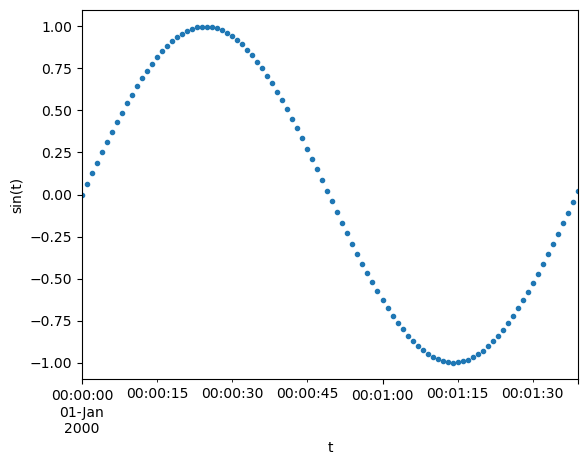

In [77]:
sin_fun = [np.sin(x/math.pi/5) for x in range(100)]
drange = pd.date_range("2000-01-01", freq='S', periods = 100)
sin_frame = pd.Series(sin_fun,
                     drange)
sin_frame.plot(marker = '.',linestyle = '', xlabel= 't', ylabel = 'sin(t)')

Replace some true value with "Nan" so as to simulate missing information

<AxesSubplot:xlabel='t', ylabel='sin(t)'>

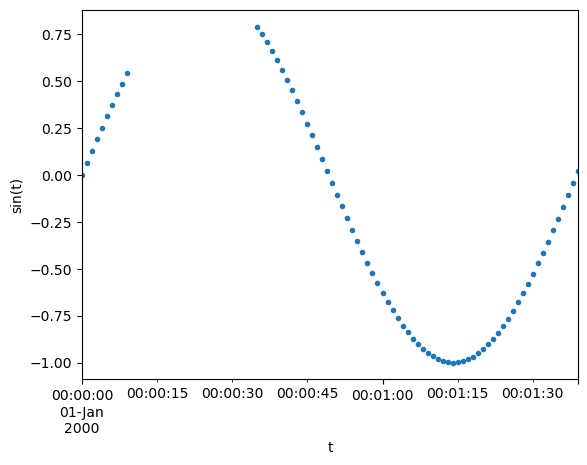

In [78]:
original_frame = sin_frame.copy(deep = True)
sin_frame[10:35] = np.nan
sin_frame.plot(marker = '.',linestyle = '', xlabel= 't', ylabel = 'sin(t)')

**Forward filling**: Last Observation Carried Forward (LOCF)

<AxesSubplot:xlabel='t', ylabel='sin(t)'>

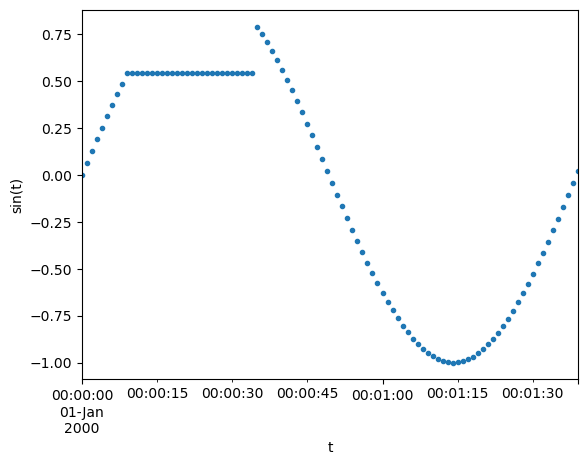

In [79]:
sin_frame.ffill().plot(marker = '.',linestyle = '', xlabel= 't', ylabel = 'sin(t)')

<AxesSubplot:xlabel='t', ylabel='sin(t)'>

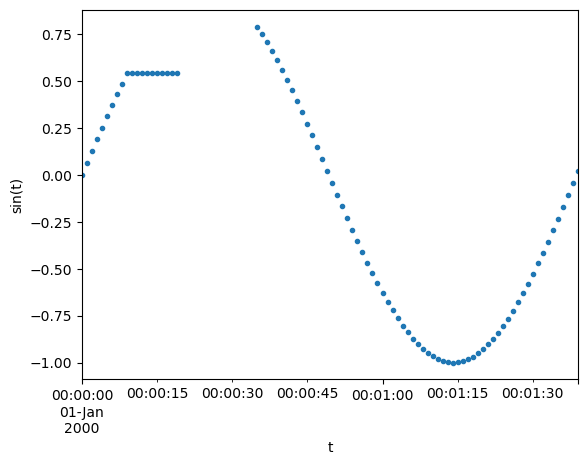

In [80]:
sin_frame.ffill(limit=10).plot(marker = '.',linestyle = '', xlabel= 't', ylabel = 'sin(t)')

**Backward filling**: Next Observation Carried Backward (NOCB)

Just as you can bring values from the past forward to fill in missing data, you can also choose to propagate values backward. However, this is a case of a **lookahead**, so you should only do this when you are not looking to predict the future from the data and when, from domain knowledge, it makes more sense to fill in data backward rather than forward in time.

<AxesSubplot:xlabel='t', ylabel='sin(t)'>

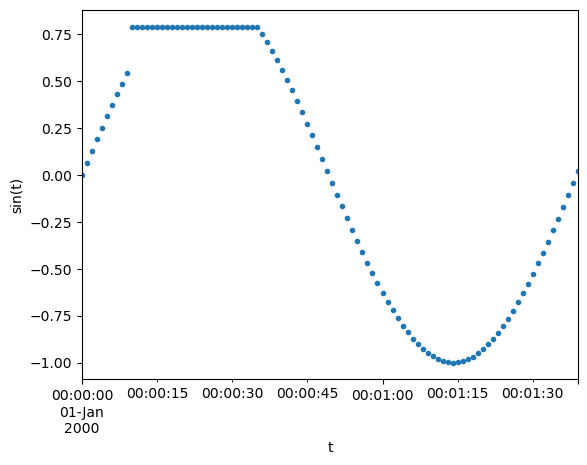

In [81]:
sin_frame.bfill().plot(marker = '.',linestyle = '', xlabel= 't', ylabel = 'sin(t)')

**Interpolation**

Interpolation techniques estimate the missing values by assuming a *geometric* relationship within a range of data points. Interpolation technique estimates an intermediate observation using past and future known data points. The usual caveats apply: allow your interpolation to have access to future data only if you accept that this creates a lookahead and you are sure this is not a problem for your task.

Among the available interpolation methods, we find:
- linear, spline, nearest, zero, slinear, quadratic, cubic, spline, barycentric, polynomial ...

In [82]:
sin_frame.head(40)

2000-01-01 00:00:00    0.000000
2000-01-01 00:00:01    0.063619
2000-01-01 00:00:02    0.126980
2000-01-01 00:00:03    0.189827
2000-01-01 00:00:04    0.251905
2000-01-01 00:00:05    0.312962
2000-01-01 00:00:06    0.372751
2000-01-01 00:00:07    0.431030
2000-01-01 00:00:08    0.487563
2000-01-01 00:00:09    0.542120
2000-01-01 00:00:10         NaN
2000-01-01 00:00:11         NaN
2000-01-01 00:00:12         NaN
2000-01-01 00:00:13         NaN
2000-01-01 00:00:14         NaN
2000-01-01 00:00:15         NaN
2000-01-01 00:00:16         NaN
2000-01-01 00:00:17         NaN
2000-01-01 00:00:18         NaN
2000-01-01 00:00:19         NaN
2000-01-01 00:00:20         NaN
2000-01-01 00:00:21         NaN
2000-01-01 00:00:22         NaN
2000-01-01 00:00:23         NaN
2000-01-01 00:00:24         NaN
2000-01-01 00:00:25         NaN
2000-01-01 00:00:26         NaN
2000-01-01 00:00:27         NaN
2000-01-01 00:00:28         NaN
2000-01-01 00:00:29         NaN
2000-01-01 00:00:30         NaN
2000-01-

<AxesSubplot:xlabel='t', ylabel='sin(t)'>

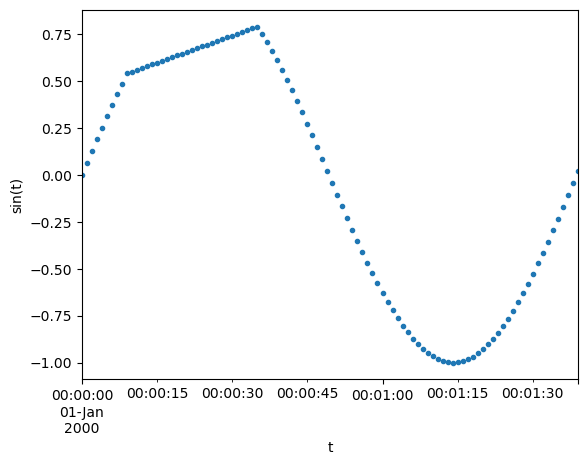

In [83]:
sin_frame.interpolate('linear').plot(marker = '.',linestyle = '', xlabel= 't', ylabel = 'sin(t)')

<AxesSubplot:xlabel='t', ylabel='sin(t)'>

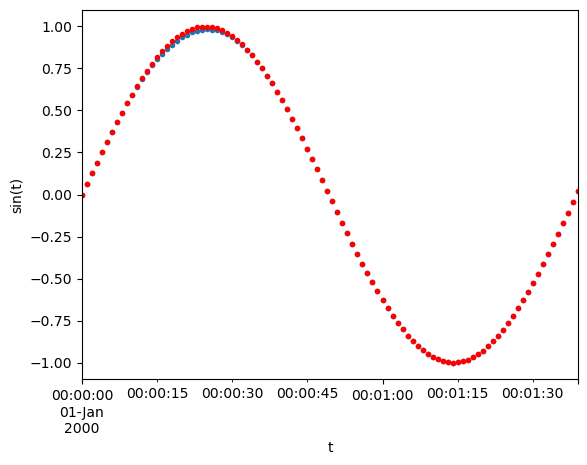

In [84]:
f,axes = plt.subplots()
sin_frame.interpolate('quadratic').plot(marker = '.',linestyle = '',axes = axes)
original_frame.plot(marker = '.',linestyle = '',color = 'r',axes = axes, xlabel= 't', ylabel = 'sin(t)')



<AxesSubplot:xlabel='t', ylabel='sin(t)'>

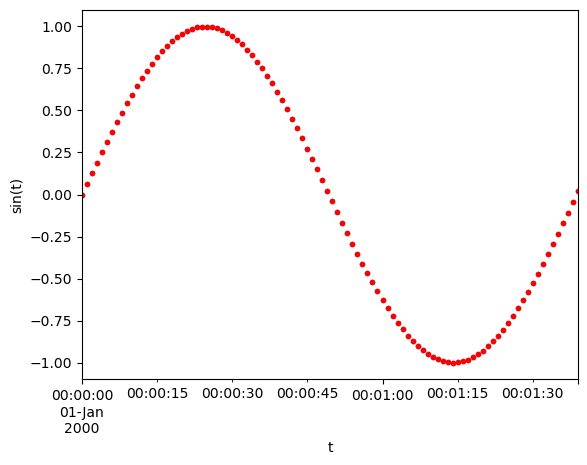

In [85]:
f,axes = plt.subplots()
sin_frame.interpolate('polynomial',order = 7).plot(marker = '.',linestyle = '',axes = axes)
original_frame.plot(marker = '.',linestyle = '',color = 'r',axes = axes, xlabel= 't', ylabel = 'sin(t)')


# Moving Window Functions

An important class of array transformation used for time series operations are statistics and other functions evaluated over a sliding window or with exponentially decaying weights. This can be useful for smoothing noisy data or for filling missing values. Note that there are many situations where missing data imputation based on moving average is a better fit for the task than a forward fill. For example if the data is noisy you should use a moving average rather than a forward fill.



Load the *stock_px* dataset. It containes the trends of stock prices for several companies.

In [86]:
close_px_all = pd.read_csv("dataset/stock_px.csv",
                           parse_dates=True, index_col=0)
close_px_all

,AAPL,MSFT,XOM,SPX
2003-01-02,7.40,21.11,29.22,909.03
2003-01-03,7.45,21.14,29.24,908.59
2003-01-06,7.45,21.52,29.96,929.01
2003-01-07,7.43,21.93,28.95,922.93
2003-01-08,7.28,21.31,28.83,909.93
...,...,...,...,...
2011-10-10,388.81,26.94,76.28,1194.89
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66


Select only the stock related to AAPL (Apple Inc.), MSFT (Microsoft Corporation) and XOM (Exxon Mobil Corporation).

In [87]:
close_px = close_px_all[["AAPL", "MSFT", "XOM"]]
close_px

,AAPL,MSFT,XOM
2003-01-02,7.40,21.11,29.22
2003-01-03,7.45,21.14,29.24
2003-01-06,7.45,21.52,29.96
2003-01-07,7.43,21.93,28.95
2003-01-08,7.28,21.31,28.83
...,...,...,...
2011-10-10,388.81,26.94,76.28
2011-10-11,400.29,27.00,76.27
2011-10-12,402.19,26.96,77.16
2011-10-13,408.43,27.18,76.37


In [88]:
len(close_px)

2214

<AxesSubplot:xlabel='time', ylabel='AAPL stock'>

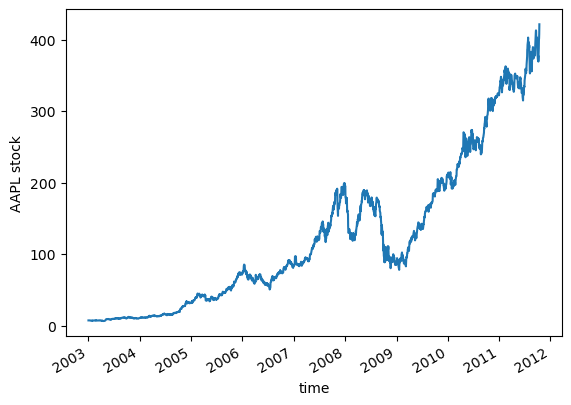

In [89]:
close_px.AAPL.plot(xlabel= 'time',ylabel = 'AAPL stock')

Resample the time series data to business day frequency. This introduce some missing values

In [90]:
close_px = close_px.resample("B").asfreq()
len(close_px)

2292

<AxesSubplot:xlabel='time', ylabel='AAPL stock'>

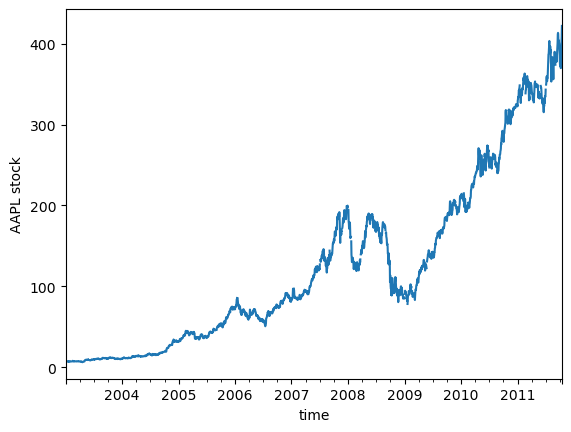

In [91]:
close_px.AAPL.plot(xlabel= 'time',ylabel = 'AAPL stock')

In [92]:
close_px = close_px.ffill()

<AxesSubplot:xlabel='time', ylabel='AAPL stock'>

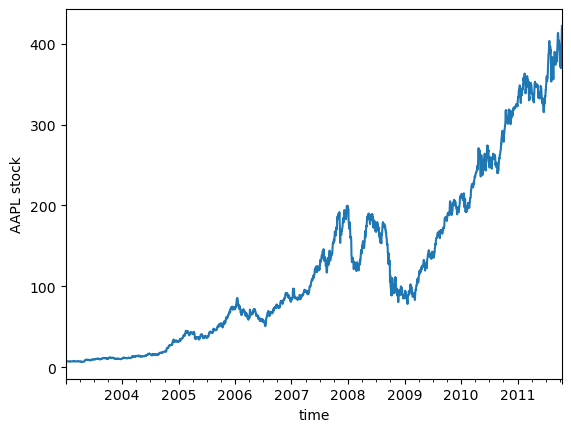

In [93]:
close_px.AAPL.plot(xlabel= 'time',ylabel = 'AAPL stock')

**Rectangular or unweighted sliding-average smooth**

The rolling operator is simlar to resample or groupby, but can be called on a Series or a Dataframe along with a window (expressed as number of periods).

By default, set the window labels as the right edge of the window index.
If parameter center is set to "True", set the window labels as the center of the window index.


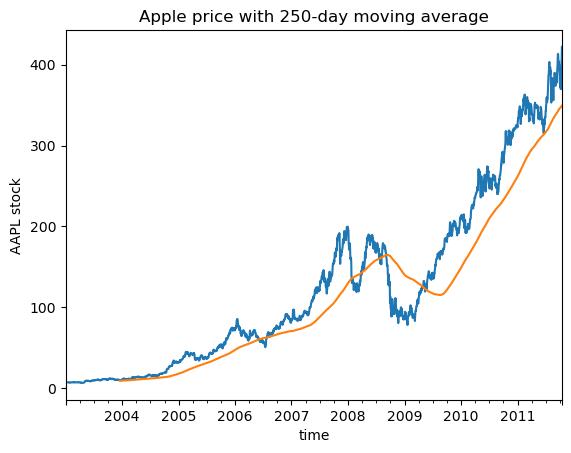

In [94]:
close_px["AAPL"].plot()
close_px["AAPL"].rolling(250).mean().plot(xlabel= 'time',ylabel = 'AAPL stock')
plt.title("Apple price with 250-day moving average")
plt.show()

With a too wide window, noise is reduced but the information carried by the signal is strongly reduced as well.

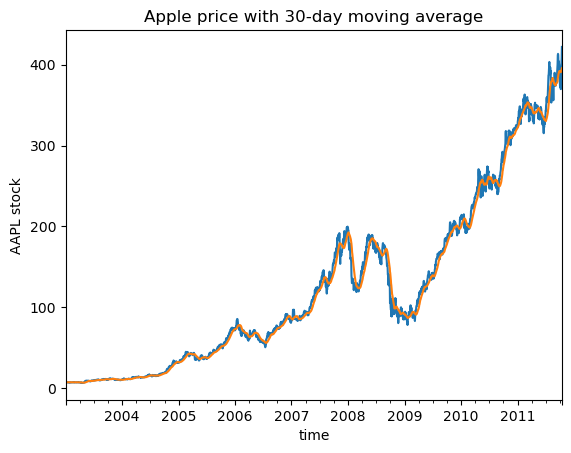

In [95]:
close_px["AAPL"].plot()
close_px["AAPL"].rolling('30D').mean().plot(xlabel= 'time',ylabel = 'AAPL stock')
plt.title("Apple price with 30-day moving average")
plt.show()

**Savitsky-Golay Smoothing Filter**


In [96]:
from scipy.signal import savgol_filter
close_px['AAPL_sg'] = savgol_filter(close_px["AAPL"], window_length = 100, polyorder = 4)

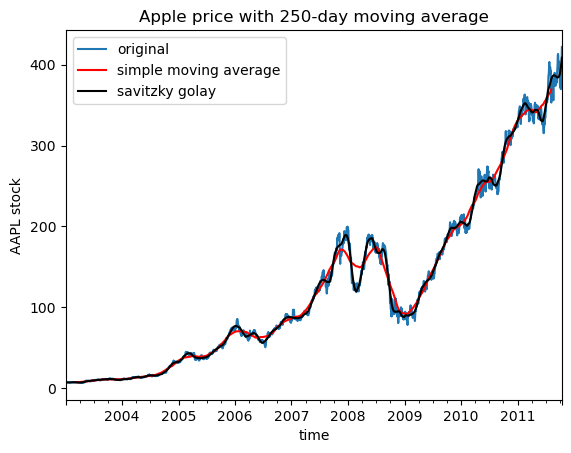

In [97]:
close_px["AAPL"].plot(label = 'original')
close_px["AAPL"].rolling(100,center = True).mean().plot(color = 'r',
                                                        label = 'simple moving average',
                                                        xlabel= 'time',
                                                        ylabel = 'AAPL stock')
close_px["AAPL_sg"].plot(label = 'savitzky golay',color = 'k')

plt.legend()
plt.title("Apple price with 250-day moving average")
plt.show()


Notice that, even if the window length is the same, Savitsky-Golay entails a better preservation of the peaks.

# <font color='blue'><ins>TASK</ins></font>
- [This repository](https://github.com/pcm-dpc/COVID-19) hosts the updated information about the evolution of the pandemic in Italy (as provided by the "Dipartimento della Protezione Civile"). One way to programmatically get access to the data is through urllib (see the snippet below)
    - Process and explore national level data.
    - Explore the repository and fetch regional level data. Then, process and explore regional level data.

In [98]:
import urllib
reponame = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/"
filename = "dpc-covid19-ita-andamento-nazionale.csv"
CSV_URL = reponame+filename
with urllib.request.urlopen(CSV_URL) as f:
    df = pd.read_csv(f,index_col = 0)

In [99]:
ENGLISH_TRANSLATION = False
ita_eng_columns = {
    'stato':'state',
    'ricoverati_con_sintomi':'hospitalized_with_symptoms', 
    'terapia_intensiva': 'intensive_care',
    'totale_ospedalizzati': 'total_hospitalized',
    'isolamento_domiciliare': 'home_isolation',
    'totale_positivi': 'total_positive',
    'variazione_totale_positivi':'total_positive_variation',
    'nuovi_positivi': 'new_positive',
    'dimessi_guariti': 'healed',
    'deceduti': 'deaths',
    'casi_da_sospetto_diagnostico': 'positive_by_symtoms',
    'casi_da_screening': 'positive_by_screening',
    'totale_casi': 'total_cases',
    'tamponi': 'pcr',
    'casi_testati': 'tested_cases',
    'note':'notes',
    'ingressi_terapia_intensiva': 'intensive_care_entrances', 
    'note_test': 'notes_tests', 
    'note_casi': 'notes_cases',
    'totale_positivi_test_molecolare': 'total_positive_molecular_test',
    'totale_positivi_test_antigenico_rapido': 'total_positive_rapid_antigen_test', 
    'tamponi_test_molecolare': 'molecular_test',
    'tamponi_test_antigenico_rapido': 'rapid_antigen_test'}
if ENGLISH_TRANSLATION:
    df.columns = [ita_eng_columns[x] for x in df.columns]

In [100]:
df.T

data,2020-02-24T18:00:00,2020-02-25T18:00:00,2020-02-26T18:00:00,2020-02-27T18:00:00,2020-02-28T18:00:00,2020-02-29T18:00:00,2020-03-01T18:00:00,2020-03-02T18:00:00,2020-03-03T18:00:00,2020-03-04T18:00:00,...,2022-11-22T17:00:00,2022-11-23T17:00:00,2022-11-24T17:00:00,2022-11-25T17:00:00,2022-11-26T17:00:00,2022-11-27T17:00:00,2022-11-28T17:00:00,2022-11-29T17:00:00,2022-11-30T17:00:00,2022-12-01T17:00:00
stato,ITA,ITA,ITA,ITA,ITA,ITA,ITA,ITA,ITA,ITA,...,ITA,ITA,ITA,ITA,ITA,ITA,ITA,ITA,ITA,ITA
ricoverati_con_sintomi,101,114,128,248,345,401,639,742,1034,1346,...,7600,7615,7613,7776,7793,7865,8040,8179,8361,8458
terapia_intensiva,26,35,36,56,64,105,140,166,229,295,...,248,241,250,256,252,274,283,289,303,320
totale_ospedalizzati,127,150,164,304,409,506,779,908,1263,1641,...,7848,7856,7863,8032,8045,8139,8323,8468,8664,8778
isolamento_domiciliare,94,162,221,284,412,543,798,927,1000,1065,...,473813,477785,484594,487020,490202,489914,481655,492208,494163,498391
totale_positivi,221,311,385,588,821,1049,1577,1835,2263,2706,...,481661,485641,492457,495052,498247,498053,489978,500676,502827,507169
variazione_totale_positivi,0,90,74,203,233,228,528,258,428,443,...,12051,3980,6816,2595,3195,-194,-8075,10698,2151,4342
nuovi_positivi,221,93,78,250,238,240,566,342,466,587,...,50285,35641,36909,34601,32412,23956,12266,50626,36981,36598
dimessi_guariti,1,1,3,45,46,50,83,149,160,276,...,23525553,23557103,23587105,23619022,23648146,23672245,23692505,23732286,23767026,23799178
deceduti,7,10,12,17,21,29,34,52,79,107,...,180899,181009,181098,181182,181271,181322,181403,181544,181630,181733
